# US Churn &mdash; Feature Engineering


## Setup

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "US_Churn"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = False
SEED = 1612

In [200]:
if COLAB:
    from google.colab import drive
    if not os.path.isdir("/content/gdrive"):
        drive.mount("/content/gdrive")

## Imports

In [201]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

## Datasets

In [202]:
df = pd.read_pickle(f"{ROOT}/data/churn.pkl")
print(df.shape)
df.head()

(3333, 20)


,State,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,KS,128,0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,2,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,0,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [203]:
# drop feature that I have not yet considered properly in EDA
for c in ["State"]:
    if c in df.columns: df.drop(c, axis='columns', inplace=True)

## Pre-process Data

In [204]:
df_train, df_test = train_test_split(df, stratify=df.Churn, train_size=0.60, random_state=SEED)
df_train.shape, df_test.shape

((1999, 19), (1334, 19))

In [205]:
target = "Churn"
cat_features = [c for c in df.select_dtypes("category").columns if c not in target]
num_features = [c for c in df.select_dtypes(["int","float"]).columns if c not in target]
features = cat_features + num_features

print(f"Traget: {target}")

print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")
print(f"Number of Features: {len(features)}")

Traget: Churn
Categorical Features: ['Area_Code', 'Intl_Plan', 'VMail_Plan']
Numerical Features: ['Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls']
Number of Features: 18


## Feature_Engineering 

Features engineering and selection decisions are carried out on `df_train` ONLY, but resulting operations should be applied to both `df_train` and `df_test`. The simplest way to do this (without repeating code) is to 

 * Perform querys on `df_train` to select new possible features.
 * Apply operations to `df` and repeat the train/test split USING THE SAME SEED.
 * You can use the target values in `df_train` but cannot use the target values in `df_test`.

### New Feature - Cranky Triskaidekaphobias

Would a feature indicating customers who complain and avoid the number 13 be useful in predicting Churn?

This is a silly feature, but illustrates the general procedure

In [206]:
my_query = df_train.query('CustServ_Calls>0 & Day_Calls!=13 & Eve_Calls!=13 & Night_Calls!=13 & Intl_Calls!=13')
my_query.head()

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
519,41,2,0,0,0,202.9,97,34.49,153.8,104,13.07,113.5,92,5.11,9.0,3,2.43,3,0
2012,134,2,0,0,0,183.8,111,31.25,123.5,92,10.50,160.7,105,7.23,6.1,2,1.65,1,0
3120,96,0,0,1,21,247.6,95,42.09,256.3,150,21.79,158.6,72,7.14,10.8,6,2.92,2,0
2450,137,1,0,0,0,109.8,120,18.67,230.5,86,19.59,255.8,103,11.51,11.9,6,3.21,1,0
859,93,2,0,0,0,267.9,114,45.54,223.0,74,18.96,262.7,90,11.82,11.3,3,3.05,3,1


In [207]:
df["Cranky_Triskaidekaphobias"] = df.apply (lambda row: (row.CustServ_Calls>0 
            and row.Day_Calls!=13 and row.Eve_Calls!=13 
            and row.Night_Calls!=13 and row.Intl_Calls!=13), axis=1)

In [208]:
# test generated feature to ensure has sufficient variability
df.Cranky_Triskaidekaphobias.value_counts()

True     2626
False     707
Name: Cranky_Triskaidekaphobias, dtype: int64

### New Feature - Using featuretools

In [101]:
import featuretools as ft

#### EntitySet

In [177]:
es = ft.EntitySet(id="US_Churn")

* adding `index` column

In [178]:
ind = list([c for c in range(3333)])
s = pd.Series(ind)
df.set_index([s])

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn,Cranky_Triskaidekaphobias
0,128,0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,True
1,107,0,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,True
2,137,0,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,False
3,84,2,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,True
4,75,0,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0,True
3329,68,0,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0,True
3330,28,1,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0,True
3331,184,1,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0,True


* Create an entity from the US_Churn dataframe
* This dataframe already has an index

In [180]:
es = es.add_dataframe(dataframe_name = "df", 
    dataframe = df,
    index = 'index'
    )
print(es)

Entityset: US_Churn
  DataFrames:
    df [Rows: 3333, Columns: 20]
  Relationships:
    No relationships


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\featuretools\entityset\entityset.py:1906: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(


* Selection of transform primitives

In [78]:
list_primitives = pd.DataFrame(ft.primitives.list_primitives())
list_primitives = list(list_primitives.drop(list_primitives.query(" `type`=='aggregation' ").index).name)
print(list_primitives)

['upper_case_word_count', 'num_words', 'less_than_equal_to', 'day', 'square_root', 'cityblock_distance', 'upper_case_count', 'is_weekend', 'percentile', 'is_leap_year', 'or', 'elmo', 'number_of_unique_words', 'greater_than_equal_to', 'number_of_common_words', 'is_federal_holiday', 'day_of_year', 'multiply_boolean', 'add_numeric', 'isin', 'rolling_outlier_count', 'latitude', 'weekday', 'cum_count', 'part_of_day', 'url_to_protocol', 'universal_sentence_encoder', 'rolling_min', 'cum_mean', 'not', 'not_equal', 'number_of_mentions', 'greater_than_equal_to_scalar', 'sine', 'add_numeric_scalar', 'is_working_hours', 'expanding_max', 'punctuation_count', 'year', 'less_than_scalar', 'quarter', 'expanding_count', 'rolling_trend', 'one_digit_postal_code', 'divide_by_feature', 'number_of_words_in_quotes', 'is_month_start', 'absolute', 'multiply_numeric', 'month', 'expanding_std', 'url_to_tld', 'whitespace_count', 'is_free_email_domain', 'modulo_numeric', 'modulo_by_feature', 'season', 'email_addres

* Final selection - excluded non-sense transform primitives for this data

In [79]:
primitives = ['subtract_numeric_scalar', 'modulo_numeric', 'exponential_weighted_std', 'add_numeric', 'divide_by_feature', 'cum_sum', 'modulo_numeric_scalar', 'percentile', 'add_numeric_scalar', 'equal', 'diff', 'scalar_subtract_numeric_feature', 'multiply_numeric_boolean', 'exponential_weighted_variance', 'greater_than', 'is_null', 'equal_scalar', 'absolute', 'cum_mean', 'multiply_numeric_scalar', 'isin', 'cum_max', 'divide_numeric_scalar', 'greater_than_equal_to', 'negate', 'less_than_equal_to_scalar', 'subtract_numeric', 'less_than', 'greater_than_equal_to_scalar', 'not', 'less_than_scalar', 'cosine', 'cum_min', 'not_equal', 'divide_numeric', 'square_root', 'same_as_previous', 'not_equal_scalar', 'sine', 'greater_than_scalar', 'less_than_equal_to', 'tangent', 'cum_count', 'multiply_numeric', 'modulo_by_feature', 'exponential_weighted_average', 'absolute_diff']

In [181]:
primitives = ['equal', 'greater_than']

* Create `new features` using selected primitives

In [182]:
# Create new features using specified primitives
features, feature_names = ft.dfs(entityset = es, target_dataframe_name = 'df',
                                      trans_primitives = primitives
                                      )
print("Number of features", len(features.columns))
features.head()

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:170: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


Number of features 419


,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Cranky_Triskaidekaphobias,Account_Length = Area_Code,Account_Length = Cranky_Triskaidekaphobias,Account_Length = CustServ_Calls,Account_Length = Day_Calls,Account_Length = Day_Charge,Account_Length = Day_Mins,Account_Length = Eve_Calls,Account_Length = Eve_Charge,Account_Length = Eve_Mins,Account_Length = Intl_Calls,Account_Length = Intl_Charge,Account_Length = Intl_Mins,Account_Length = Intl_Plan,Account_Length = Night_Calls,Account_Length = Night_Charge,Account_Length = Night_Mins,Account_Length = VMail_Message,Account_Length = VMail_Plan,Account_Length = index,Area_Code = Cranky_Triskaidekaphobias,Area_Code = CustServ_Calls,Area_Code = Day_Calls,Area_Code = Day_Charge,Area_Code = Day_Mins,Area_Code = Eve_Calls,Area_Code = Eve_Charge,Area_Code = Eve_Mins,Area_Code = Intl_Calls,Area_Code = Intl_Charge,Area_Code = Intl_Mins,Area_Code = Intl_Plan,Area_Code = Night_Calls,Area_Code = Night_Charge,Area_Code = Night_Mins,Area_Code = VMail_Message,Area_Code = VMail_Plan,Area_Code = index,Cranky_Triskaidekaphobias = CustServ_Calls,Cranky_Triskaidekaphobias = Day_Calls,Cranky_Triskaidekaphobias = Day_Charge,Cranky_Triskaidekaphobias = Day_Mins,Cranky_Triskaidekaphobias = Eve_Calls,Cranky_Triskaidekaphobias = Eve_Charge,Cranky_Triskaidekaphobias = Eve_Mins,Cranky_Triskaidekaphobias = Intl_Calls,Cranky_Triskaidekaphobias = Intl_Charge,Cranky_Triskaidekaphobias = Intl_Mins,Cranky_Triskaidekaphobias = Intl_Plan,Cranky_Triskaidekaphobias = Night_Calls,Cranky_Triskaidekaphobias = Night_Charge,Cranky_Triskaidekaphobias = Night_Mins,Cranky_Triskaidekaphobias = VMail_Message,Cranky_Triskaidekaphobias = VMail_Plan,Cranky_Triskaidekaphobias = index,CustServ_Calls = Day_Calls,CustServ_Calls = Day_Charge,CustServ_Calls = Day_Mins,CustServ_Calls = Eve_Calls,CustServ_Calls = Eve_Charge,CustServ_Calls = Eve_Mins,CustServ_Calls = Intl_Calls,CustServ_Calls = Intl_Charge,CustServ_Calls = Intl_Mins,CustServ_Calls = Intl_Plan,CustServ_Calls = Night_Calls,CustServ_Calls = Night_Charge,CustServ_Calls = Night_Mins,CustServ_Calls = VMail_Message,CustServ_Calls = VMail_Plan,CustServ_Calls = index,Day_Calls = Day_Charge,Day_Calls = Day_Mins,Day_Calls = Eve_Calls,Day_Calls = Eve_Charge,Day_Calls = Eve_Mins,Day_Calls = Intl_Calls,Day_Calls = Intl_Charge,Day_Calls = Intl_Mins,Day_Calls = Intl_Plan,Day_Calls = Night_Calls,Day_Calls = Night_Charge,Day_Calls = Night_Mins,Day_Calls = VMail_Message,Day_Calls = VMail_Plan,Day_Calls = index,Day_Charge = Day_Mins,Day_Charge = Eve_Calls,Day_Charge = Eve_Charge,Day_Charge = Eve_Mins,Day_Charge = Intl_Calls,Day_Charge = Intl_Charge,Day_Charge = Intl_Mins,Day_Charge = Intl_Plan,Day_Charge = Night_Calls,Day_Charge = Night_Charge,Day_Charge = Night_Mins,Day_Charge = VMail_Message,Day_Charge = VMail_Plan,Day_Charge = index,Day_Mins = Eve_Calls,Day_Mins = Eve_Charge,Day_Mins = Eve_Mins,Day_Mins = Intl_Calls,Day_Mins = Intl_Charge,Day_Mins = Intl_Mins,Day_Mins = Intl_Plan,Day_Mins = Night_Calls,Day_Mins = Night_Charge,Day_Mins = Night_Mins,Day_Mins = VMail_Message,Day_Mins = VMail_Plan,Day_Mins = index,Eve_Calls = Eve_Charge,Eve_Calls = Eve_Mins,Eve_Calls = Intl_Calls,Eve_Calls = Intl_Charge,Eve_Calls = Intl_Mins,Eve_Calls = Intl_Plan,Eve_Calls = Night_Calls,Eve_Calls = Night_Charge,Eve_Calls = Night_Mins,Eve_Calls = VMail_Message,Eve_Calls = VMail_Plan,Eve_Calls = index,Eve_Charge = Eve_Mins,Eve_Charge = Intl_Calls,Eve_Charge = Intl_Charge,Eve_Charge = Intl_Mins,Eve_Charge = Intl_Plan,Eve_Charge = Night_Calls,Eve_Charge = Night_Charge,Eve_Charge = Night_Mins,Eve_Charge = VMail_Message,Eve_Charge = VMail_Plan,Eve_Charge = index,Eve_Mins = Intl_Calls,Eve_Mins = Intl_Charge,Eve_Mins = Intl_Mins,Eve_Mins = Intl_Plan,Eve_Mins = Night_Calls,Eve_Mins = Night_Charge,Eve_Mins = Night_Mins,Eve_Mins = VMail_Message,Eve_Mins = VMail_Plan,Ev

In [183]:
df = pd.DataFrame(features)

#### Processing the dataset

##### Dropping NaN and Infinite values

In [186]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [187]:
df = df.dropna(axis=1,how='any')

##### Add Churn

In [184]:
df[target] = churn 

### New Feature - ????

In [ ]:
['Churn = CustServ_Calls',
 'Churn = VMail_Message',
 'Churn = VMail_Plan',
 'VMail_Message > CustServ_Calls',
 'VMail_Message > Intl_Charge',
 'Intl_Calls <= VMail_Message',
 'VMail_Message <= CustServ_Calls',
 'VMail_Message <= Intl_Charge',
 'VMail_Message <= 0',
 'Churn != Cranky_Triskaidekaphobias',
 'Churn != VMail_Message',
 'Churn != VMail_Plan']

### New Feature - ????

### New Feature - ????

### New Feature - ????

### Pre-Processing Data (2)

In [189]:
df_train, df_test = train_test_split(df, stratify=df[target], test_size=.40, random_state=SEED)
features = df.columns.tolist()
if target in features: features.remove(target)
print(f"Number of features {len(features)}\n{features}")

Number of features 419
['Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Cranky_Triskaidekaphobias', 'Account_Length = Area_Code', 'Account_Length = Cranky_Triskaidekaphobias', 'Account_Length = CustServ_Calls', 'Account_Length = Day_Calls', 'Account_Length = Day_Charge', 'Account_Length = Day_Mins', 'Account_Length = Eve_Calls', 'Account_Length = Eve_Charge', 'Account_Length = Eve_Mins', 'Account_Length = Intl_Calls', 'Account_Length = Intl_Charge', 'Account_Length = Intl_Mins', 'Account_Length = Intl_Plan', 'Account_Length = Night_Calls', 'Account_Length = Night_Charge', 'Account_Length = Night_Mins', 'Account_Length = VMail_Message', 'Account_Length = VMail_Plan', 'Account_Length = index', 'Area_Code = Cranky_Triskaidekaphobias', 'Area_Code = CustServ_Calls', 'Area_Code = Day_

In [190]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,features].values)
y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,features].values)
y_test = df_test.Churn.values

## Model Selection

In [191]:
models = {
    "LR": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "DT(max_depth=3)": DecisionTreeClassifier(max_depth=3),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
}

def train_models():
    best = {'name':None, 'mean':0}
    
    for name,model in models.items():
    
        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
        mean = scores.mean()
        std = scores.std()
        
        print ("\nModel %s" % name)
        print ("\tCV scores: " +  ", ".join([f"{s:.2f}" for s in scores]))
        print (f"\tmean={mean:.2%} std={std:.4f}")
    
        if mean>best['mean']:
            best = {'name':name, 'mean':mean}

    print (f"\nBest Performing Model {best['name']} with (mean CV of) accuracy = {best['mean']:.2%}" )
    

In [192]:
train_models()

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st


Model LR
	CV scores: 0.86, 0.88, 0.86, 0.85, 0.84, 0.89, 0.89, 0.88, 0.85, 0.87
	mean=86.84% std=0.0158

Model DT
	CV scores: 0.94, 0.91, 0.89, 0.88, 0.89, 0.92, 0.89, 0.92, 0.91, 0.88
	mean=90.09% std=0.0182

Model DT(max_depth=3)
	CV scores: 0.90, 0.92, 0.90, 0.88, 0.91, 0.92, 0.89, 0.92, 0.91, 0.85
	mean=89.74% std=0.0186

Model KNN
	CV scores: 0.87, 0.87, 0.86, 0.86, 0.83, 0.86, 0.84, 0.85, 0.88, 0.86
	mean=86.04% std=0.0131

Model SVC
	CV scores: 0.86, 0.88, 0.86, 0.86, 0.85, 0.86, 0.88, 0.86, 0.87, 0.88
	mean=86.64% std=0.0083

Best Performing Model DT with (mean CV of) accuracy = 90.09%


## Feature Selection

Next we are going to try to reduce the number of features using [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) a recursive feature elimination with cross-validation function.

RFECV needs a classifier that returns information about feature importance either through a `coef_` attribute or through a `feature_importances_` attribute. 
Of our models given above will work, only `LogisticRegression` and `DT` provide this information


In [193]:
print("Number of features starting:", len(features))

Number of features starting: 419


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Optimal number of features : 21


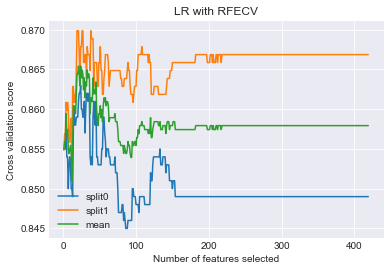

In [194]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

name = 'LR'  # use any LR, DT
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring="accuracy")
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [195]:
len(rfecv.support_), len(features)

(419, 419)

In [196]:
# list of features selected
if len(rfecv.support_)<len(features):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected = np.array(features)[rfecv.support_].tolist()
print(len(features_selected))
features_selected

21


['Intl_Plan',
 'VMail_Message',
 'Day_Mins',
 'Day_Charge',
 'Night_Mins',
 'CustServ_Calls',
 'Cranky_Triskaidekaphobias',
 'Account_Length = Night_Calls',
 'Cranky_Triskaidekaphobias = CustServ_Calls',
 'Cranky_Triskaidekaphobias = VMail_Message',
 'Intl_Calls = Intl_Mins',
 'Intl_Calls = Intl_Plan',
 'Intl_Charge = Intl_Plan',
 'Intl_Plan = VMail_Plan',
 'CustServ_Calls > VMail_Message',
 'Day_Charge > VMail_Message',
 'Day_Mins > Eve_Mins',
 'Eve_Charge > VMail_Message',
 'Eve_Mins > Night_Mins',
 'Intl_Calls > CustServ_Calls',
 'Night_Calls > Day_Mins']

### Training - After Feature Selection

In [197]:
display(df.loc[:, features_selected + [target]].head(100))

# normalise 
X_train = scaler.fit_transform(df_train.loc[:,features_selected].values)
y_train = df_train.Churn.values
X_test = scaler.transform(df_test.loc[:,features_selected].values)
y_test = df_test.Churn.values

train_models()

,Intl_Plan,VMail_Message,Day_Mins,Day_Charge,Night_Mins,CustServ_Calls,Cranky_Triskaidekaphobias,Account_Length = Night_Calls,Cranky_Triskaidekaphobias = CustServ_Calls,Cranky_Triskaidekaphobias = VMail_Message,Intl_Calls = Intl_Mins,Intl_Calls = Intl_Plan,Intl_Charge = Intl_Plan,Intl_Plan = VMail_Plan,CustServ_Calls > VMail_Message,Day_Charge > VMail_Message,Day_Mins > Eve_Mins,Eve_Charge > VMail_Message,Eve_Mins > Night_Mins,Intl_Calls > CustServ_Calls,Night_Calls > Day_Mins,Churn
index,,,,,,,,,,,,,,,,,,,,,,
0,0,25,265.1,45.07,244.7,1,True,False,True,False,False,False,False,False,False,True,True,False,False,True,False,0
1,0,26,161.6,27.47,254.4,1,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,0
2,0,0,243.4,41.38,162.6,0,False,False,True,True,False,False,False,True,False,True,True,True,False,True,False,0
3,1,0,299.4,50.90,196.9,2,True,False,False,False,False,False,False,False,True,True,True,True,False,True,False,0
4,1,0,166.7,28.34,186.9,3,True,False,False,False,False,False,False,False,True,True,True,True,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,278.4,47.33,163.2,1,True,False,True,False,False,False,False,True,True,True,True,True,False,True,False,0
96,0,0,160.1,27.22,174.1,0,False,False,True,True,False,False,False,True,False,True,False,True,True,True,False,0
97,0,0,198.2,33.69,190.9,4,True,False,False,False,False,False,False,True,True,True,False,True,True,False,False,0



Model LR
	CV scores: 0.89, 0.86, 0.86, 0.83, 0.85, 0.88, 0.89, 0.85, 0.85, 0.89
	mean=86.64% std=0.0181

Model DT
	CV scores: 0.85, 0.85, 0.89, 0.86, 0.85, 0.86, 0.91, 0.86, 0.86, 0.85
	mean=86.49% std=0.0162

Model DT(max_depth=3)
	CV scores: 0.89, 0.90, 0.90, 0.89, 0.91, 0.91, 0.89, 0.92, 0.89, 0.86
	mean=89.39% std=0.0142

Model KNN
	CV scores: 0.88, 0.90, 0.89, 0.92, 0.86, 0.91, 0.86, 0.89, 0.89, 0.90
	mean=89.00% std=0.0173

Model SVC
	CV scores: 0.89, 0.91, 0.89, 0.91, 0.89, 0.91, 0.92, 0.89, 0.91, 0.89
	mean=89.89% std=0.0107

Best Performing Model SVC with (mean CV of) accuracy = 89.89%


In [198]:
display(df.loc[:, features_selected + [target]].value_counts())

Intl_Plan  VMail_Message  Day_Mins  Day_Charge  Night_Mins  CustServ_Calls  Cranky_Triskaidekaphobias  Account_Length = Night_Calls  Cranky_Triskaidekaphobias = CustServ_Calls  Cranky_Triskaidekaphobias = VMail_Message  Intl_Calls = Intl_Mins  Intl_Calls = Intl_Plan  Intl_Charge = Intl_Plan  Intl_Plan = VMail_Plan  CustServ_Calls > VMail_Message  Day_Charge > VMail_Message  Day_Mins > Eve_Mins  Eve_Charge > VMail_Message  Eve_Mins > Night_Mins  Intl_Calls > CustServ_Calls  Night_Calls > Day_Mins  Churn
0          0              146.4     24.89       230.1       1               True                       False                         True                                        False                                      False                   False                   False                    True                    True                            True                        False                True                        False                  True                         False         

## Submit

 * Creates zip file to upload of notebooks in project

In [ ]:
import glob
from zipfile import ZipFile

archive = f'{ROOT}/US_Churn_-_Feature_Engineering.zip'

if COLAB:
    files_to_upload = list(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/US_Churn*.ipynb"))
else: 
    files_to_upload = list(glob.glob("US_Churn*.ipynb"))
print(f"Creating zip archive with notbooks {files_to_upload} ...")

with ZipFile(archive,'w') as zip:
    for file in files_to_upload:
        basename = file.split("/Colab Notebooks/")[-1]
        zip.write(file, basename)

Creating zip archive with notbooks ['US_Churn-01-Import.ipynb', 'US_Churn-02-EDA.ipynb', 'US_Churn-03-Baseline_Model.ipynb', 'US_Churn-04-Feature_Engineering.ipynb'] ...
